In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [3]:
import tensorflow as tf

2024-06-08 19:52:15.987528: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-08 19:52:16.704738: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/yw/miniconda3/envs/tf/lib/
2024-06-08 19:52:16.704852: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/yw/miniconda3/envs/tf/lib/
2024-06-08 19:52:16.704860: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries

In [4]:
import tensorflow.keras.backend as K

In [5]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*6)])
  except RuntimeError as e:
    print(e)

In [7]:
df = pd.read_csv('edge_images/preprocessed.csv')

# preprocessing

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53416 entries, 0 to 53415
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            53416 non-null  object 
 1   Sex           53416 non-null  object 
 2   Height        53416 non-null  object 
 3   Weight        53416 non-null  object 
 4   Hair          53416 non-null  object 
 5   Eyes          53416 non-null  object 
 6   Race          53416 non-null  object 
 7   Sex Offender  53416 non-null  bool   
 8   Offense       53416 non-null  object 
 9   Height_cm     53416 non-null  float64
 10  Weight_kg     53416 non-null  float64
dtypes: bool(1), float64(2), object(8)
memory usage: 4.1+ MB


In [9]:
df.drop(columns=['Height', 'Weight', 'Sex Offender', 'Offense', 'Hair', 'Eyes'], inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53416 entries, 0 to 53415
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         53416 non-null  object 
 1   Sex        53416 non-null  object 
 2   Race       53416 non-null  object 
 3   Height_cm  53416 non-null  float64
 4   Weight_kg  53416 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.0+ MB


In [11]:
data = pd.get_dummies(df, columns=['Sex', 'Race'])
data = data.drop(columns=['ID'])

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53416 entries, 0 to 53415
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Height_cm           53416 non-null  float64
 1   Weight_kg           53416 non-null  float64
 2   Sex_Female          53416 non-null  bool   
 3   Sex_Male            53416 non-null  bool   
 4   Race_Amer Indian    53416 non-null  bool   
 5   Race_Asian          53416 non-null  bool   
 6   Race_Bi-Racial      53416 non-null  bool   
 7   Race_Black          53416 non-null  bool   
 8   Race_Hispanic       53416 non-null  bool   
 9   Race_Not Available  53416 non-null  bool   
 10  Race_White          53416 non-null  bool   
dtypes: bool(9), float64(2)
memory usage: 1.3 MB


In [13]:
train_data = data[:int(0.8*len(data))]
val_data = data[int(0.1*len(data)):]
test_data = data[int(0.1*len(data)):]

train_data = train_data[~train_data['Race_Not Available']]
val_data = val_data[~val_data['Race_Not Available']]
test_data = test_data[~test_data['Race_Not Available']]

# convert to tuple
train_data = (tf.constant(train_data.drop(columns=['Weight_kg']).values, dtype=tf.float32), train_data['Weight_kg'].values)
val_data = (tf.constant(val_data.drop(columns=['Weight_kg']).values, dtype=tf.float32), val_data['Weight_kg'].values)
test_data = (tf.constant(test_data.drop(columns=['Weight_kg']).values, dtype=tf.float32), test_data['Weight_kg'].values)

In [14]:
train_data[0].shape

TensorShape([42708, 10])

In [15]:
BATCH_SIZE = 128
train_set = tf.data.Dataset.from_tensor_slices(train_data).shuffle(10000).batch(BATCH_SIZE, drop_remainder=True).prefetch(1)
val_set = tf.data.Dataset.from_tensor_slices(val_data).shuffle(10000).batch(BATCH_SIZE, drop_remainder=True).prefetch(1)
test_set = tf.data.Dataset.from_tensor_slices(test_data).shuffle(10000).batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# model 1

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(train_data[0].shape[1:])),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 10)               40        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               2816      
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                        

In [18]:
history = model.fit(train_set, epochs=50, validation_data=val_set, callbacks=[early_stopping])

Epoch 1/50


435/435 [==============================] - 6s 10ms/step - loss: 6245.8594 - mean_absolute_error: 76.8309 - val_loss: 3326.9800 - val_mean_absolute_error: 55.3854
Epoch 2/50
435/435 [==============================] - 4s 10ms/step - loss: 1580.1606 - mean_absolute_error: 33.7807 - val_loss: 394.9867 - val_mean_absolute_error: 14.5852
Epoch 3/50
435/435 [==============================] - 4s 10ms/step - loss: 289.5587 - mean_absolute_error: 12.6323 - val_loss: 262.5794 - val_mean_absolute_error: 12.2015
Epoch 4/50
435/435 [==============================] - 4s 10ms/step - loss: 254.4687 - mean_absolute_error: 12.1430 - val_loss: 258.1283 - val_mean_absolute_error: 12.1634
Epoch 5/50
435/435 [==============================] - 4s 10ms/step - loss: 253.6714 - mean_absolute_error: 12.1401 - val_loss: 256.0703 - val_mean_absolute_error: 12.2532
Epoch 6/50
435/435 [==============================] - 5s 10ms/step - loss: 253.3806 - mean_absolute_error: 12.1340 - val_loss: 256.5197 - val_mean_absolu

In [19]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

In [20]:
def modelplot(history, data, val_data):
    plt.plot(history.history[data])
    plt.plot(history.history[val_data])
    plt.title('Model'+ data)
    plt.ylabel(data)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()



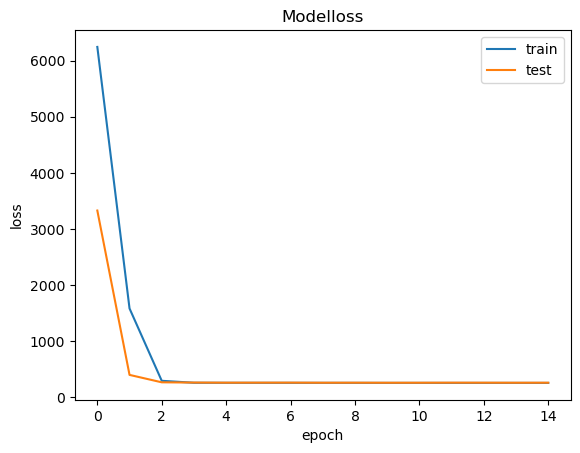

In [21]:
modelplot(history, 'loss', 'val_loss')

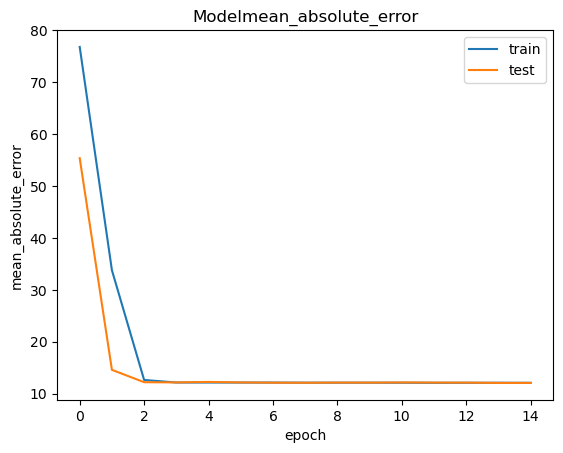

In [22]:
modelplot(history, 'mean_absolute_error', 'val_mean_absolute_error')

In [23]:
model.evaluate(test_set)

489/489 [==============================] - 2s 3ms/step - loss: 254.8607 - mean_absolute_error: 12.1221


[254.8606719970703, 12.122122764587402]

In [24]:
model.save_weights('models/structured data model-v1')

# model 2

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(train_data[0].shape[1:])),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 10)               40        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               1408      
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                        

In [18]:
history = model.fit(train_set, epochs=50, validation_data=val_set, callbacks=[early_stopping])

Epoch 1/50


435/435 [==============================] - 5s 9ms/step - loss: 6259.3442 - mean_absolute_error: 76.9138 - val_loss: 3364.5530 - val_mean_absolute_error: 55.7366
Epoch 2/50
435/435 [==============================] - 4s 9ms/step - loss: 1588.4944 - mean_absolute_error: 33.8966 - val_loss: 398.7405 - val_mean_absolute_error: 14.6791
Epoch 3/50
435/435 [==============================] - 4s 9ms/step - loss: 289.6026 - mean_absolute_error: 12.6341 - val_loss: 256.9685 - val_mean_absolute_error: 12.2094
Epoch 4/50
435/435 [==============================] - 4s 9ms/step - loss: 254.1568 - mean_absolute_error: 12.1474 - val_loss: 257.7486 - val_mean_absolute_error: 12.1420
Epoch 5/50
435/435 [==============================] - 4s 9ms/step - loss: 254.2974 - mean_absolute_error: 12.1591 - val_loss: 256.2666 - val_mean_absolute_error: 12.1750
Epoch 6/50
435/435 [==============================] - 4s 9ms/step - loss: 253.2831 - mean_absolute_error: 12.1271 - val_loss: 256.0013 - val_mean_absolute_err

In [19]:
def modelplot(history, data, val_data):
    plt.plot(history.history[data])
    plt.plot(history.history[val_data])
    plt.title('Model'+ data)
    plt.ylabel(data)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()

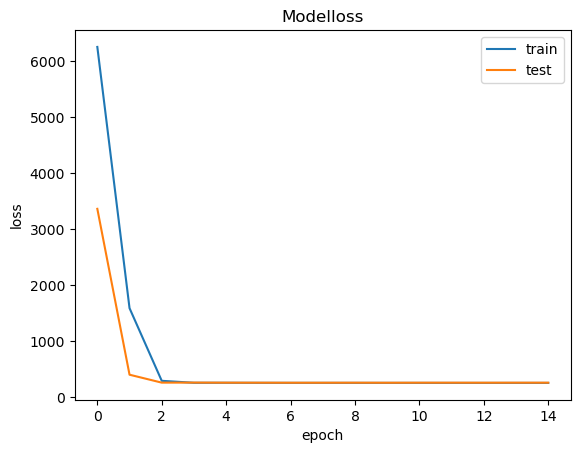

In [20]:
modelplot(history, 'loss', 'val_loss')

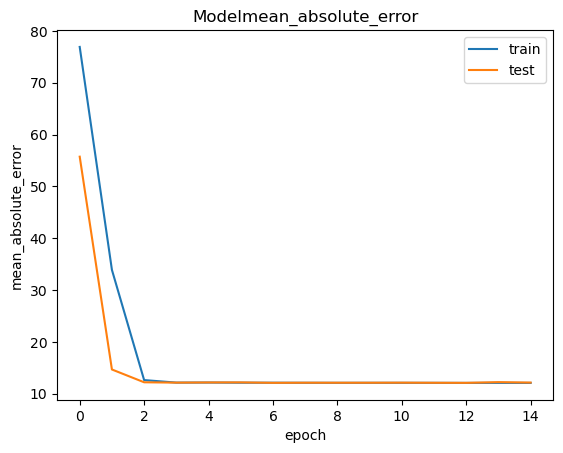

In [21]:
modelplot(history, 'mean_absolute_error', 'val_mean_absolute_error')

In [22]:
model.evaluate(test_set)

105/489 [=====>........................] - ETA: 1s - loss: 249.0161 - mean_absolute_error: 11.9096

489/489 [==============================] - 2s 3ms/step - loss: 255.1276 - mean_absolute_error: 12.1239


[255.12759399414062, 12.123855590820312]

In [23]:
model.save_weights('models/structured data model-v2')

# model 3

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(train_data[0].shape[1:])),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 10)               40        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 64)                704       
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_2 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                        

In [18]:
history = model.fit(train_set, epochs=100, validation_data=val_set, callbacks=[early_stopping])

Epoch 1/100


333/333 [==============================] - 5s 11ms/step - loss: 7354.3643 - mean_absolute_error: 84.2753 - val_loss: 5987.9272 - val_mean_absolute_error: 75.7746
Epoch 2/100
333/333 [==============================] - 3s 10ms/step - loss: 5887.3662 - mean_absolute_error: 74.9899 - val_loss: 4694.8281 - val_mean_absolute_error: 66.6922
Epoch 3/100
333/333 [==============================] - 3s 9ms/step - loss: 3778.6963 - mean_absolute_error: 59.1454 - val_loss: 2633.2407 - val_mean_absolute_error: 48.8530
Epoch 4/100
333/333 [==============================] - 3s 9ms/step - loss: 1911.8976 - mean_absolute_error: 40.3733 - val_loss: 1170.2594 - val_mean_absolute_error: 30.4536
Epoch 5/100
333/333 [==============================] - 3s 10ms/step - loss: 793.7486 - mean_absolute_error: 23.3294 - val_loss: 458.3530 - val_mean_absolute_error: 16.2179
Epoch 6/100
333/333 [==============================] - 3s 10ms/step - loss: 360.4947 - mean_absolute_error: 13.9915 - val_loss: 270.7023 - val_mea

In [19]:
def modelplot(history, data, val_data):
    plt.plot(history.history[data])
    plt.plot(history.history[val_data])
    plt.title('Model'+ data)
    plt.ylabel(data)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()

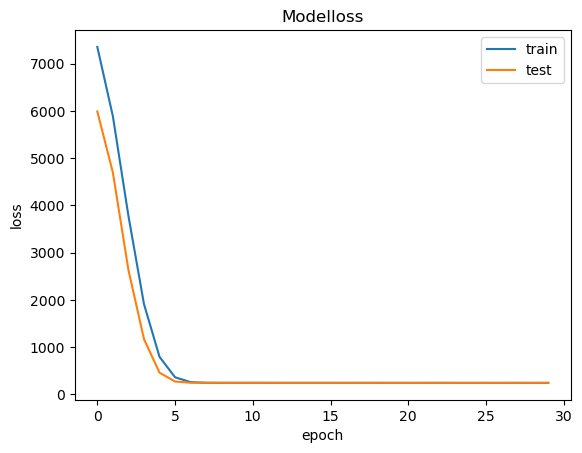

In [20]:
modelplot(history, 'loss', 'val_loss')

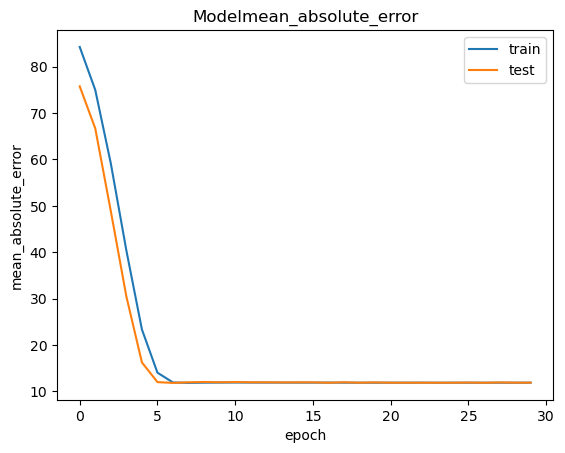

In [21]:
modelplot(history, 'mean_absolute_error', 'val_mean_absolute_error')

In [22]:
model.evaluate(test_set)

  1/375 [..............................] - ETA: 14s - loss: 193.6237 - mean_absolute_error: 10.9304

375/375 [==============================] - 1s 3ms/step - loss: 243.0356 - mean_absolute_error: 11.8388


[243.03558349609375, 11.838807106018066]

In [23]:
model.save_weights('models/structured_model')

# extra tree regressor

In [37]:
import sklearn
import sklearn.ensemble
from sklearn.metrics import mean_absolute_error, mean_squared_error

model = sklearn.ensemble.ExtraTreesRegressor(n_jobs=-1)
model.fit(train_data[0], train_data[1])

ExtraTreesRegressor(n_jobs=-1)

In [39]:
pred = model.predict(test_data[0])
mean_squared_error(test_data[1], pred), mean_absolute_error(test_data[1], pred)

(254.80910804285062, 12.251619826605735)